# Klasifikacija teksta pomoću GPT2 i Tensorflow-a

U ovom projektu ćemo klasifikovati tvitove (analiza sentimenta).

Videćemo kakve rezultate daje fino podešavanje (fine-tuning) prethodno obučenog modela (GPT2).

In [2]:
# Na početku vršimo import korišćenih biblioteka.

import math
import tensorflow as tf
from transformers import GPT2Tokenizer, TFGPT2Model

import pandas as pd

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Vršimo učitavanje odgovarajućeg fajla.


In [42]:
df = pd.read_csv('covid_tweets.csv')

In [45]:
df.size

2728

Podela podataka na trening i test skup.

In [46]:
X = df['lemmatized_tweets']
y = df['VADER_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [47]:
X_train

335     recent report show number of vaccine injury in...
1661    I just got boost and when I accidently cut mys...
56        trump donaldjtrumpjr kimkbaltimore karilake ...
667     could a patent free vaccine offer a covid solu...
1383    be this story true life insurer refuse to cove...
                              ...                        
526     tune in to the amazing schedule at the event o...
1690    with the corbevax approval vaccination could n...
17      european drug maker sanofi and gsk announce po...
11      once claim overpopulation to be control and fa...
763       vaccination vaccinemandate vaccine omicron h...
Name: lemmatized_tweets, Length: 1023, dtype: object

Podešavamo MAX_LENGTH (maksimalna dužina sekvence) kao prosečna dužina + 2

In [48]:
MAX_LENGTH = math.ceil((X_train.apply(lambda x: len(str(x).split())).mean()))+2
MAX_LENGTH

30

Inicijalizacija gpt2 tokenizatora i inicijalizacija PAD i EOS tokena.

In [49]:
PAD_TOKEN = "<|pad|>"
EOS_TOKEN = "<|endoftext|>"

# this will download and initialize the pre trained tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2",
    pad_token=PAD_TOKEN,
    eos_token=EOS_TOKEN,
    max_length=MAX_LENGTH,
    is_split_into_words=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Postavljamo EOS token na kraj svakog pojedinačnog tvita.

In [50]:
X_train = [str(ex) + EOS_TOKEN for ex in X_train]
X_test = [str(ex) + EOS_TOKEN for ex in X_test]

Prosleđujemo tvitove kroz tokenizator, dodajući im praznine do maksimalne dužine. Ovo je lista, pa je moramo spojiti da bismo kreirali ulaz koji odgovara tenzoru.

In [51]:
X_train_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_train]
X_test_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_test]

X_train_in = tf.squeeze(tf.convert_to_tensor(X_train_), axis=1)
X_test_in = tf.squeeze(tf.convert_to_tensor(X_test_), axis=1)

c:\Users\stevan.grujic\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [52]:
X_train_in[0]

<tf.Tensor: shape=(30,), dtype=int32, numpy=
array([49921,   989,   905,  1271,   286, 12319,  5095,   287,   308,
        2224,    88,   714,   307,   510,   284,  1865,   991,  4574,
         329, 39849,   312, 12319, 14598,   329,   477,  4044,   300,
        2306,   263, 19496])>

Takođe ćemo dobiti masku od tokenizatora (1 je token, 0 je pad token), isto kao što smo uradili za ulaze.

In [53]:
X_train_mask_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_train]
X_test_mask_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_test]

X_train_mask = tf.squeeze(tf.convert_to_tensor(X_train_mask_), axis=1)
X_test_mask = tf.squeeze(tf.convert_to_tensor(X_test_mask_), axis=1)

Sada smo spremni da pustimo ulaze kroz model.
Zatim je potrebno inicijalizovati GPT2 za TF i postaviti ga u režim obuke.

In [54]:
model = TFGPT2Model.from_pretrained("gpt2", use_cache=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id)
model.training = True

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [55]:
model.resize_token_embeddings(len(tokenizer))

Postavljamo prethodno obučene slojeve GPT2 kao "non trainable".

In [56]:
for layer in model.layers:
    layer.trainable = False

In [57]:
model.summary()

Model: "tfgpt2_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 124440576 
 r)                                                              
                                                                 
Total params: 124,440,576
Trainable params: 0
Non-trainable params: 124,440,576
_________________________________________________________________


Zatim gradimo dodatne slojeve GPT2-a.
Model prima tenzore tokena i maske. Izlazi su poslednja skrivena stanja poslednjeg sloja u transformatoru. Ova stanja se smanjuju koristeći srednju vrednost preko dužine sekvence, prolaze kroz 2 potpuno povezana sloja sa dropout-om između. Izlazni sloj ima dva čvora (softmax aktivaciona funkcija za verovatnoće) za dve klase koje želimo predvideti (Negativno i Pozitivno).

In [58]:
input = tf.keras.layers.Input(shape=(None,), dtype='int32')
mask = tf.keras.layers.Input(shape=(None,), dtype='int32')
x = model(input, attention_mask=mask)
#x = x.last_hidden_state[:, -1]
x = tf.reduce_mean(x.last_hidden_state, axis=1)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

In [59]:
clf = tf.keras.Model([input, mask], output)

In [60]:
clf.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 tfgpt2_model_1 (TFGPT2Model)   TFBaseModelOutputWi  124440576   ['input_3[0][0]',                
                                thPastAndCrossAtten               'input_4[0][0]']                
                                tions(last_hidden_s                                               
                                tate=(None, None, 7                                         

Zatim kompajliramo model birajući learning rate, loss function i metriku za praćenje.

In [61]:
base_learning_rate = 0.0005
optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
#loss=tf.keras.losses.BinaryCrossentropy()
loss=tf.keras.losses.SparseCategoricalCrossentropy()

clf.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [62]:
callbacks = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", verbose=1, patience=10, restore_best_weights=True)

Poslednja stvar koju je potrebno uraditi je pripremiti ciljni tenzor.

In [63]:
def map_sentiment(value):
  if value == 'Negative':
    return 0
  if value == 'Positive':
    return 1

In [64]:
y_train_ = y_train.map(map_sentiment)
y_test_ = y_test.map(map_sentiment)

In [65]:
y_train_in = tf.constant(y_train_, dtype=tf.int32)
y_test_in = tf.constant(y_test_, dtype=tf.int32)

In [66]:
tf.config.experimental_run_functions_eagerly(True)

Zatim treniramo model tako što prosleđujemo broj epoha, veličinu batch-a i udeo za validaciju.

In [67]:
history = clf.fit([X_train_in, X_train_mask], y_train_in, epochs=50, batch_size=32, validation_split=0.2, callbacks=callbacks)

Epoch 1/50


c:\Users\stevan.grujic\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


26/26 [==============================] - 131s 5s/step - loss: 6.4215 - accuracy: 0.4242 - val_loss: 1.2975 - val_accuracy: 0.3659
Epoch 2/50
26/26 [==============================] - 133s 5s/step - loss: 1.9280 - accuracy: 0.5086 - val_loss: 0.8033 - val_accuracy: 0.6390
Epoch 3/50
26/26 [==============================] - 122s 5s/step - loss: 1.2943 - accuracy: 0.5660 - val_loss: 0.6513 - val_accuracy: 0.6195
Epoch 4/50
26/26 [==============================] - 122s 5s/step - loss: 1.0647 - accuracy: 0.5648 - val_loss: 0.6419 - val_accuracy: 0.6537
Epoch 5/50
26/26 [==============================] - 124s 5s/step - loss: 0.8843 - accuracy: 0.5440 - val_loss: 0.6250 - val_accuracy: 0.6439
Epoch 6/50
26/26 [==============================] - 129s 5s/step - loss: 0.7624 - accuracy: 0.5538 - val_loss: 0.6247 - val_accuracy: 0.6488
Epoch 7/50
26/26 [==============================] - 131s 5s/step - loss: 0.6799 - accuracy: 0.5758 - val_loss: 0.6335 - val_accuracy: 0.6293
Epoch 8/50
26/26 [======

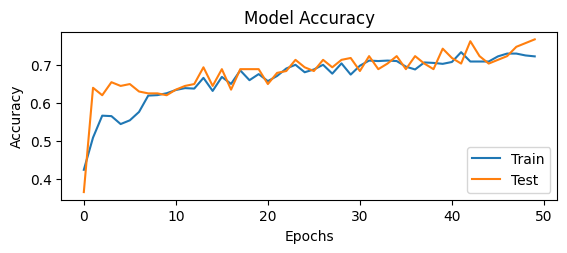

In [85]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right');

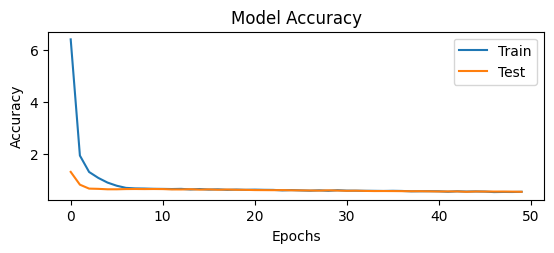

In [89]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right');

Sada možemo evaluirati model na testnom skupu.

In [68]:
clf.evaluate([X_test_in, X_test_mask], y_test_in)

11/11 [==============================] - 21s 2s/step - loss: 0.5580 - accuracy: 0.7038


[0.5580079555511475, 0.703812301158905]

In [69]:
clf.training = False
y_pred = clf.predict([X_test_in, X_test_mask])

11/11 [==============================] - 21s 2s/step


In [70]:
y_pred_out = tf.math.argmax(y_pred, axis=-1)
y_pred_out

<tf.Tensor: shape=(341,), dtype=int64, numpy=
array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
     

Sada možemo evaluirati model na testnom skupu koristeći izveštaj klasifikacije (classification report) i matricu konfuzije (confusion matrix).

In [72]:
print(classification_report(y_test_in, y_pred_out))

              precision    recall  f1-score   support

           0       0.63      0.59      0.61       134
           1       0.75      0.78      0.76       207

    accuracy                           0.70       341
   macro avg       0.69      0.68      0.69       341
weighted avg       0.70      0.70      0.70       341



Primjećujemo odmah da model, u celini, ima dobru preciznost i odziv za sve klase. Model ima više poteškoća u predviđanju negativne klase (0), posebno u odzivu.

Od svih predviđenih negativnih, 60% su zaista negativni - model ima pristojnu preciznost. Od svih koji su zaista negativni, samo 56% je predviđeno kao negativno - model ima poteškoća u prepoznavanju (odzivu) negativne klase.

Ispod se nalazi matrica konfuzije koja pomaže boljem razumijevanju situacije.

In [74]:
confusion_df = pd.DataFrame(confusion_matrix(y_test_in, y_pred_out))
confusion_df.index = ['Actual 0', 'Actual 1']
confusion_df.columns = ['Predicted 0', 'Predicted 1']
confusion_df

,Predicted 0,Predicted 1
Actual 0,79,55
Actual 1,46,161


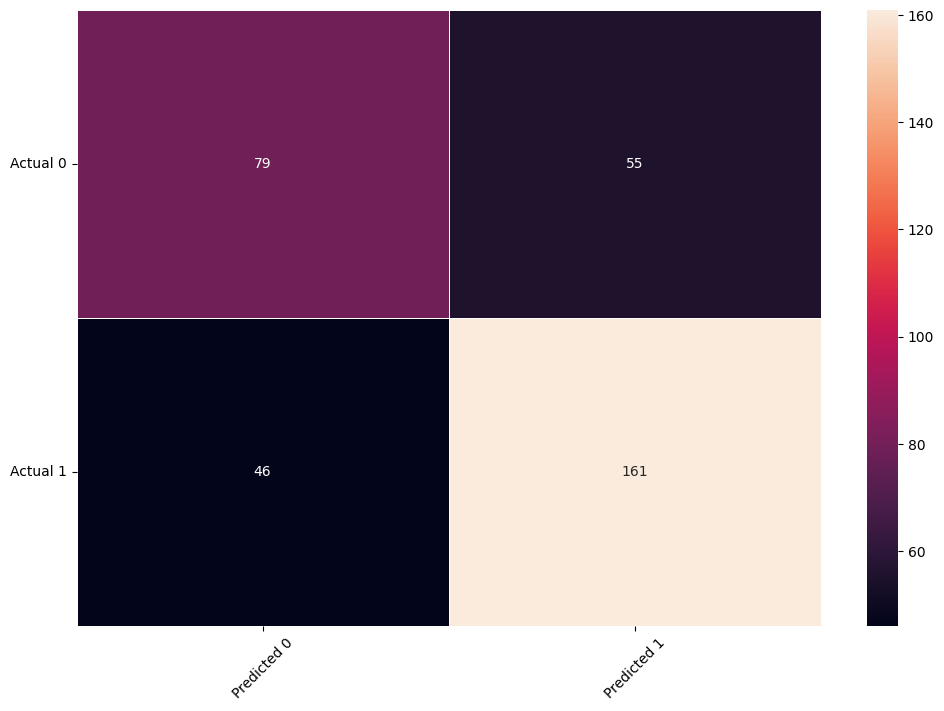

In [75]:
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_df, annot=True, fmt='d', linewidths=0.5) 
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

Detaljan opis rada nalazi se u teorijskom delu projekta.